# Imports

In [1]:
import pandas as pd
import numpy as np
import timeit
import os
import sys
import os
import json
sys.path.append("..")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight,compute_class_weight
import matplotlib.pyplot as plt
import fasttext

from src.utils import write_metrics
from src.preprocessing import deep_clean_tweet, clean_tweet_for_transformers
from src.utils import read_data
from src.utils import plot_result
from src.utils import train_model, evaluate_model
from src.utils import compute_metrics
from src.utils import set_seed
#set_seed(20042022)


# Load Training Dataset

In [2]:
#Load trainig dataset
filename = '../data/webis_train.csv'
train_df = read_data(filename)

# Cleaning Tweets

In [3]:
#Apply cleaning funcitons to tweets
train_df['cleanedText'] = train_df.postText.apply(lambda x: deep_clean_tweet(x))
##Make sure that no empty string remains in 'cleanedText'
train_df  = train_df.loc[train_df.cleanedText != '']

## Plot cleaned tweet lenght distribution

12.0


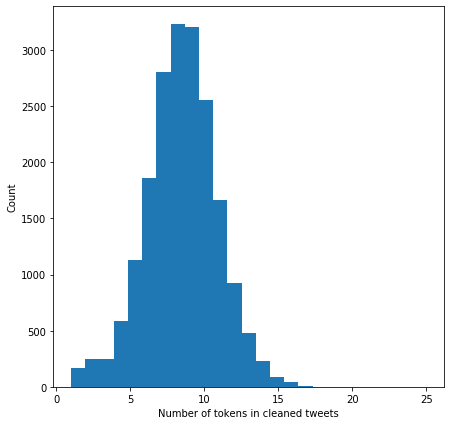

In [4]:
lenghts =  [len(x) for x in train_df['cleanedText'].str.split()]
percentile = np.percentile(lenghts,95)
print(percentile)

# Plot histogram of tweets lenght distribution in order to define the max_len parameter for the model
plt.figure(figsize=(7, 7))
plt.hist(lenghts, bins=25)
plt.xlabel('Number of tokens in cleaned tweets')
plt.ylabel('Count')
plt.show()

# Vocabulary and Feature Extraction

In [5]:
max_seq_len = 20

#preparing a tokenizer for segments on training data 
x_tokenizer = Tokenizer(oov_token = 'UNK')
x_tokenizer.fit_on_texts(train_df["cleanedText"].values)

#filter x_tokenizer by deleting items based on word counts
low_count_words = [w for w,c in x_tokenizer.word_counts.items() if c < 3]
for w in low_count_words:
    del x_tokenizer.word_index[w]
    del x_tokenizer.word_docs[w]
    del x_tokenizer.word_counts[w]    

#Apply tokenizer to the sets
X_tr = x_tokenizer.texts_to_sequences(train_df["cleanedText"].values) 

#Set token for padding sequences
x_tokenizer.word_index['PAD'] = 0
x_tokenizer.index_word[0] = 'PAD'

print(len(x_tokenizer.word_index))
X_train = pad_sequences(maxlen=max_seq_len, sequences=X_tr, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

8376


## Compute Class Weights

In [6]:
##Calculate class_weights to attenuate the unbalanced classification problem 
y_train = train_df.truthClass.values
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = ['no-clickbait', 'clickbait'],
                                        y = y_train                                                   
                                    )

class_weights = dict(zip([0,1], class_weights))
print(class_weights)

{0: 0.6593648429035753, 1: 2.0687274272360314}


## Import fastText pretrained embeddings

In [7]:
#to download the embeddings run:
#fasttext.util.download_model('en', if_exists='ignore')  # English
#store them in data/embeddings to make the code work

ft = fasttext.load_model('../data/embeddings/cc.en.300.bin')

## Build Embeddings weights matrix

In [8]:
 #Build embedding matrix for our vocabulary
embedding_matrix = np.zeros((len(x_tokenizer.word_index), 300))

##set trained embeddings to a matrix
for j, dict_word in enumerate(x_tokenizer.word_index.keys()):
    if dict_word != 'UNK' and dict_word != 'PAD':
        
        embedding_matrix[j] = ft.get_word_vector(dict_word)
        
print(embedding_matrix.shape)
#to save the embeddings matrix
#np.save('../data/embeddings/embeddings_matrix.npy', embedding_matrix)

(8376, 300)


# GRU model

### Training

In [9]:
embedding_dim = 300

def GRU_model(gru_units, dropout_rate, embedding_matrix):
    
    model = Sequential()
    inputs = Input(shape=(max_seq_len), name='inputs')
    emb = Embedding(input_dim=len(x_tokenizer.word_index), output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = True)(inputs)
    lstm = GRU(gru_units, return_sequences=True)(emb)
    gmp = GlobalMaxPooling1D()(lstm)
    drop = Dropout(dropout_rate)(gmp)
    output = Dense(1, activation='sigmoid')(drop)
    model = Model(inputs, output, name='lstm_model')
    model.summary()

    return model

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 300)           2512800   
_________________________________________________________________
gru (GRU)                    (None, 20, 512)           1250304   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 3,763,617
Trainable params: 3,763,617
Non-trainable params: 0
______________________________________________

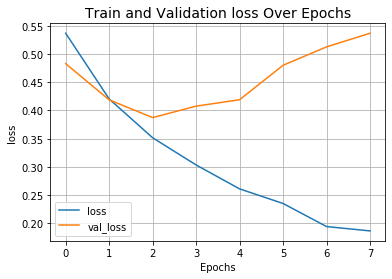

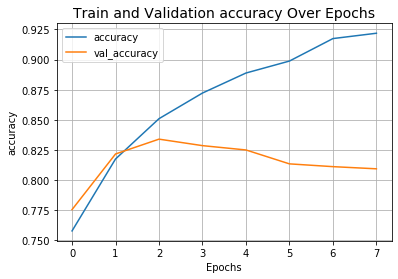

In [10]:
y_train = train_df.label.values
#Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2, embedding_matrix = embedding_matrix)
model, history, runtime = train_model(model,X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128)

### Load Test Dataset

In [11]:
# Load test dataset
filename = '../data/webis_test.csv'
test_df = read_data(filename)

In [12]:
max_seq_len = 20
#Apply same preprocessing and tokenizer to test dataset tweets
test_df['cleanedText'] = test_df.postText.apply(lambda x: deep_clean_tweet(x))
test_df  = test_df.loc[test_df.cleanedText != '']

X_te = x_tokenizer.texts_to_sequences(test_df["cleanedText"].values) 
X_test = pad_sequences(maxlen=max_seq_len, sequences=X_te, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

### Evaluation

In [13]:
y_test = test_df.label.values
#Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.3684 - accuracy: 0.8414
Test loss: 0.3683548867702484
Test accuracy 0.8413840532302856

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.87      0.93      0.90     14454
   clickbait       0.71      0.55      0.62      4447

    accuracy                           0.84     18901
   macro avg       0.79      0.74      0.76     18901
weighted avg       0.83      0.84      0.83     18901



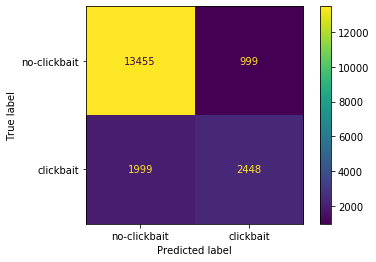

In [14]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [15]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8413840537537697
F1 Score:  0.620217887002787
Precision Score:  0.7101827676240209
Recall Score:  0.5504834720035979


In [16]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_fastText_hardPreproc_model.h5')
with open(path + '/01_gru_fastText_hardPreproc_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [17]:
#Save metrics and runtime
name = 'gru_fastText_hardPreproc'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

### Training with ClassWeights

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 512)           1250304   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 3,763,617
Trainable params: 3,763,617
Non-trainable params: 0
______________________________________________

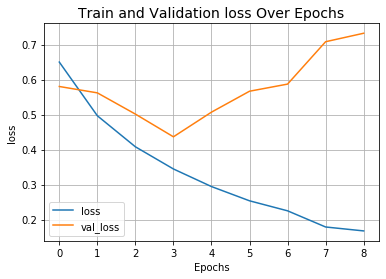

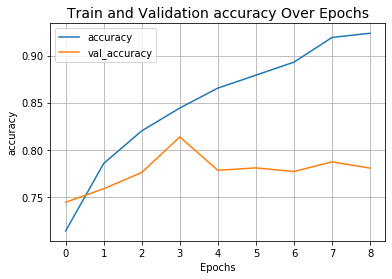

In [18]:
##Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2, embedding_matrix = embedding_matrix)
model, history, runtime = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [19]:
##Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.4138 - accuracy: 0.8195
Test loss: 0.41382360458374023
Test accuracy 0.8194804787635803

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.90      0.85      0.88     14454
   clickbait       0.60      0.71      0.65      4447

    accuracy                           0.82     18901
   macro avg       0.75      0.78      0.76     18901
weighted avg       0.83      0.82      0.82     18901



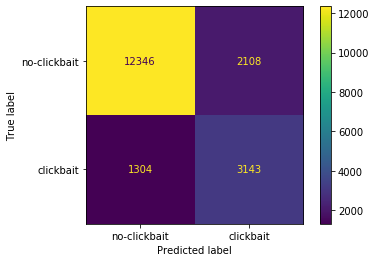

In [20]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [21]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8194804507698006
F1 Score:  0.6481748814188493
Precision Score:  0.5985526566368311
Recall Score:  0.706768608050371


In [22]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_fastText_hardPreproc_classWeights_model.h5')
with open(path + '/01_gru_fastText_hardPreproc_classWeights_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [23]:
#Save metrics and runtime
name = 'gru_fastText_hardPreproc_classWeights'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

# Cleaning Tweets - soft version

In [24]:
#Apply cleaning funcitons to tweets
train_df['cleanedText'] = train_df.postText.apply(lambda x: clean_tweet_for_transformers(x))
##Make sure that no empty string remains in 'cleanedText'
train_df  = train_df.loc[train_df.cleanedText != '']

## Plot cleaned tweet lenght distribution

21.0


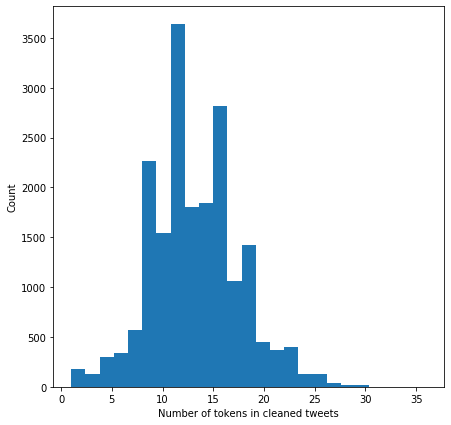

In [25]:
lenghts =  [len(x) for x in train_df['cleanedText'].str.split()]
percentile = np.percentile(lenghts,95)
print(percentile)

# Plot histogram of tweets lenght distribution in order to define the max_len parameter for the model
plt.figure(figsize=(7, 7))
plt.hist(lenghts, bins=25)
plt.xlabel('Number of tokens in cleaned tweets')
plt.ylabel('Count')
plt.show()

# Vocabulary and Feature Extraction

In [26]:
max_seq_len = 40

#preparing a tokenizer for segments on training data 
x_tokenizer = Tokenizer(oov_token = 'UNK')
x_tokenizer.fit_on_texts(train_df["cleanedText"].values)

#filter x_tokenizer by deleting items based on word counts
low_count_words = [w for w,c in x_tokenizer.word_counts.items() if c < 3]
for w in low_count_words:
    del x_tokenizer.word_index[w]
    del x_tokenizer.word_docs[w]
    del x_tokenizer.word_counts[w]    

#Apply tokenizer to the sets
X_tr = x_tokenizer.texts_to_sequences(train_df["cleanedText"].values) 

#Set token for padding sequences
x_tokenizer.word_index['PAD'] = 0
x_tokenizer.index_word[0] = 'PAD'

print(len(x_tokenizer.word_index))
X_train = pad_sequences(maxlen=max_seq_len, sequences=X_tr, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

8822


## Build Embeddings weights matrix

In [27]:
 #Build embedding matrix for our vocabulary
embedding_matrix = np.zeros((len(x_tokenizer.word_index), 300))

##set trained embeddings to a matrix
for j, dict_word in enumerate(x_tokenizer.word_index.keys()):
    if dict_word != 'UNK' and dict_word != 'PAD':
        
        embedding_matrix[j] = ft.get_word_vector(dict_word)
        
print(embedding_matrix.shape)
#to save the embeddings_matrix run:
#np.save('../data/embeddings/embeddings_matrix.npy', embedding_matrix)

(8822, 300)


# GRU model

### Training

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 300)           2646600   
_________________________________________________________________
gru_2 (GRU)                  (None, 40, 512)           1250304   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 3,897,417
Trainable params: 3,897,417
Non-trainable params: 0
______________________________________________

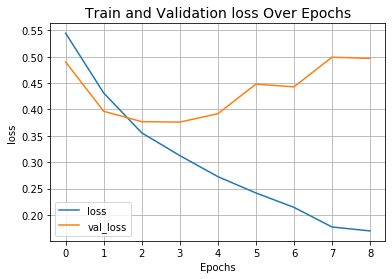

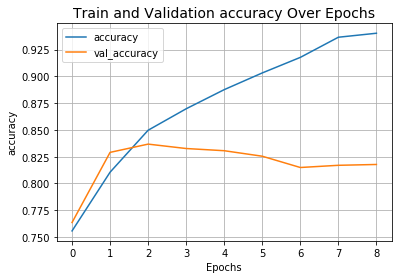

In [28]:
#Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2, embedding_matrix = embedding_matrix)
model, history, runtime = train_model(model,X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128)

In [29]:
max_seq_len = 40
#Apply same preprocessing and tokenizer to test dataset tweets
test_df['cleanedText'] = test_df.postText.apply(lambda x: clean_tweet_for_transformers(x))
test_df  = test_df.loc[test_df.cleanedText != '']

X_te = x_tokenizer.texts_to_sequences(test_df["cleanedText"].values) 
X_test = pad_sequences(maxlen=max_seq_len, sequences=X_te, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

### Evaluation

In [30]:
#Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.3579 - accuracy: 0.8461
Test loss: 0.3579423725605011
Test accuracy 0.8461456894874573

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.88      0.92      0.90     14454
   clickbait       0.70      0.61      0.65      4447

    accuracy                           0.85     18901
   macro avg       0.79      0.77      0.78     18901
weighted avg       0.84      0.85      0.84     18901



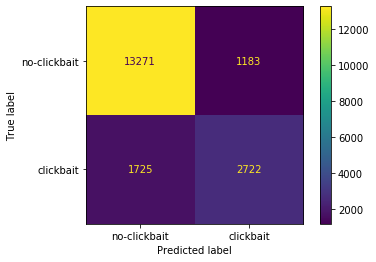

In [31]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [32]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8461457065763717
F1 Score:  0.6518199233716475
Precision Score:  0.6970550576184379
Recall Score:  0.6120980436249157


In [33]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_fastText_softPreproc_model.h5')
with open(path + '/01_gru_fastText_softPreproc_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [34]:
#Save metrics and runtime
name = 'gru_fastText_softPreproc'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

### Training with ClassWeights

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 300)           2646600   
_________________________________________________________________
gru_3 (GRU)                  (None, 40, 512)           1250304   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 3,897,417
Trainable params: 3,897,417
Non-trainable params: 0
______________________________________________

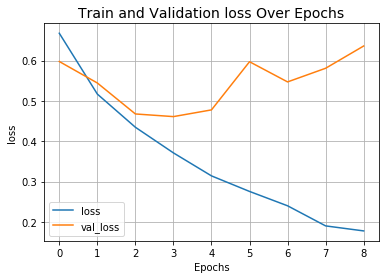

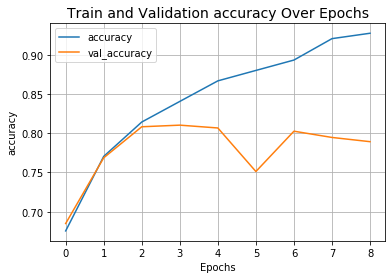

In [35]:
##Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2, embedding_matrix = embedding_matrix)
model, history, runtime = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [36]:
##Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 4ms/step - loss: 0.4338 - accuracy: 0.8158
Test loss: 0.43380433320999146
Test accuracy 0.815829873085022

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.92      0.83      0.87     14454
   clickbait       0.58      0.77      0.66      4447

    accuracy                           0.82     18901
   macro avg       0.75      0.80      0.77     18901
weighted avg       0.84      0.82      0.82     18901



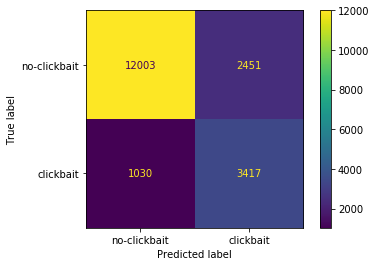

In [37]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [38]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8158298502724723
F1 Score:  0.6625302956858943
Precision Score:  0.5823108384458078
Recall Score:  0.7683831796716888


In [39]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_fastText_softPreproc_classWeights_model.h5')
with open(path + '/01_gru_fastText_softPreproc_classWeights_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [40]:
#Save metrics and runtime
name = 'gru_fastText_softPreproc_classWeights'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  